In [1]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

In [3]:
# Generate a sparse positive definite matrix in numpy
def generate_sparse_matrix(n, density):
    A = np.random.randn(n, n)
    A = A.T @ A
    A[np.random.rand(n, n) > density] = 0
    return A

def test_positive_definite():
    A = generate_sparse_matrix(100, 0.1)
    assert np.all(np.linalg.eigvals(A) > 0)

In [4]:
edf_file_path = 'data/eegmmidb/files/S088/S088R03.edf'
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

In [37]:
raw = get_raw(edf_file_path, filter=False)
annotations = get_annotations(edf_file_path)
annotation_dict = get_window_dict(raw, annotations)

In [6]:
mmidb_path = Path(r"/home/s194260/BENDR-XAI/data/eegmmidb/files")

In [7]:
src = get_src(src_path)
fwd = get_fwd(raw.info, trans, src_path, bem_path)
cov = get_cov(raw)

In [8]:
parcellation_name = "aparc.a2009s"
labels = get_labels(subjects_dir, parcellation_name = parcellation_name)

In [9]:
vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

In [10]:
from pathlib import Path
mmidb_path = Path(r"/mnt/c/Users/anders/OneDriveDTU/Dokumenter/BENDR-XAI/data/eegmmidb/files")

In [11]:
delta_activity = np.load("mmidb_aparc.a2009s_1.0_1.0_4.0_parallel.npy", allow_pickle=True).item()
theta_activity = np.load("mmidb_aparc.a2009s_1.0_4.0_8.0_parallel.npy", allow_pickle=True).item()
alpha_activity = np.load("mmidb_aparc.a2009s_1.0_8.0_12.0_parallel.npy", allow_pickle=True).item()
beta_activity = np.load("mmidb_aparc.a2009s_1.0_12.0_30.0_parallel.npy", allow_pickle=True).item()
gamma_activity = np.load("mmidb_aparc.a2009s_1.0_30.0_70.0_parallel.npy", allow_pickle=True).item()

In [28]:
activity = gamma_activity['S001']['S001R03']['T2'][0]
activity = (activity - np.min(activity)) / (np.max(activity) - np.min(activity))
activity = activity.reshape(np.array(labels).shape)

In [29]:
values = activity_to_source_values(activity, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

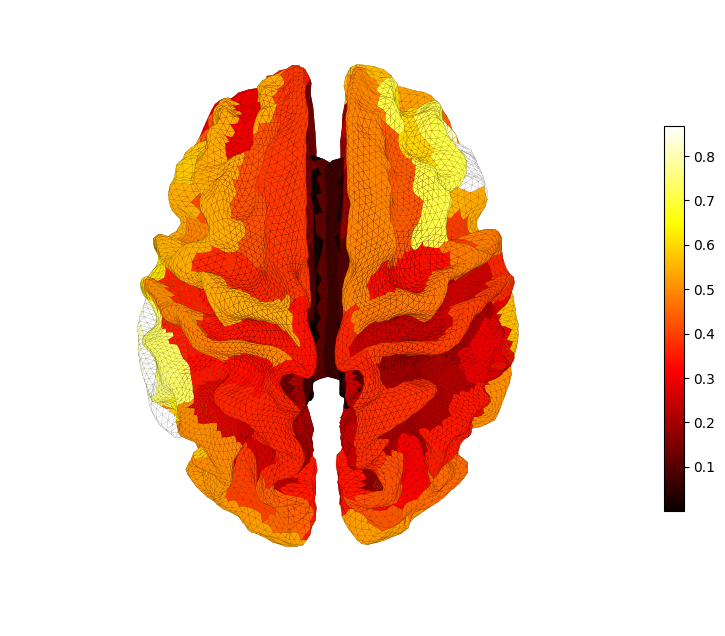

In [30]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

lh_mesh.set_array(tris_values[0])
#fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(tris_values[1])
fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, -90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.tight_layout()
plt.show()

## Brain region activity sort

In [20]:
for i in range(len(labels[0])):
    lh_idx = np.argsort(activity[0])[::-1][i]
    rh_idx = np.argsort(activity[1])[::-1][i]
    lh_name = labels[0][lh_idx].name
    rh_name = labels[1][rh_idx].name
    print('{0:.2f} {1:55}  {2:.2f} {3}'.format(activity[0][lh_idx], lh_name, activity[1][rh_idx], rh_name))

1.00 Pole_occipital-lh                                        0.89 Pole_occipital-rh
0.99 G_oc-temp_lat-fusifor-lh                                 0.85 G_and_S_transv_frontopol-rh
0.97 G_temporal_inf-lh                                        0.79 G_occipital_middle-rh
0.95 S_collat_transv_ant-lh                                   0.77 G_and_S_occipital_inf-rh
0.95 G_temporal_middle-lh                                     0.77 G_occipital_sup-rh
0.90 S_temporal_inf-lh                                        0.77 S_oc_middle_and_Lunatus-rh
0.82 S_oc-temp_lat-lh                                         0.76 G_and_S_frontomargin-rh
0.81 G_temp_sup-Plan_polar-lh                                 0.71 G_temporal_middle-rh
0.80 G_and_S_occipital_inf-lh                                 0.67 G_cuneus-rh
0.78 Pole_temporal-lh                                         0.64 G_temporal_inf-rh
0.74 G_occipital_sup-lh                                       0.63 S_oc_sup_and_transversal-rh
0.74 S_oc_middle_and_

## Brain activity plot

In [48]:
sources[0].shape

(10242, 3)

In [49]:
tmp.data[10242:,0]

array([1400.08494401,  889.65557425, 1965.12385648, ..., 1605.81052996,
       1228.42071515, 1041.69398191])

In [51]:
values = np.sum(stc.data**2, axis=1).reshape(2, 10242)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="viridis")

lh_mesh.set_array(tris_values[0])
fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(tris_values[1])
fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, 90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

plt.show()

: 

: 